![image](dependencies/open-science-prize.png)

## Better `SWAP` Gates

In this notebook we will generate circuits to characterize the standard `SWAP` gate with the intention of building a better performing `SWAP` gate using Qiskit Pulse. The `SWAP` gate is a two qubit gate which `SWAP`s the states of qubit 1 with qubit 2. The standard `SWAP` gate is implemented as 3 standard `CNOT` gates, i.e. `CNOT`(q1,q2) $\rightarrow$ `CNOT`(q2,q1) $\rightarrow$ `CNOT`(q1,q2). It is a gate that is necessary to perform many algorithms especially for hardware platforms which have limited or fixed qubit-qubit connectivity. It thus facilitates gates between qubits that are not physically connected to one another. 

Unfortunately, the `SWAP` gate is a very costly gate to implement in terms of execution time and error budget, especially if gates must be performed between qubits that are very far from each other.  Therefore, improving the performance of the `SWAP` gate can improve algorithmic performance and can even boost the quantum volume of a given system.

**The goal of this challenge is to come up with an improved `SWAP` gate whose fidelity is measured using interleaved randomized benchmarking which will be shown in this notebook.** You may conside using Qiskit Pulse, or work at the gate level using Qiskit's built in gates, to achieve this.

## Imports

Begin by importing the necessary packages and defining the functions we will need for the benchmarking measurements.

In [228]:
# Needed for functions
import numpy as np
from matplotlib import pyplot as plt
import time
from IPython.display import display, clear_output

# Qiskit imports
import qiskit
from qiskit import QuantumCircuit, Aer, IBMQ
from qiskit import transpile, schedule, assemble, execute
from qiskit.tools.monitor import job_monitor
import qiskit.tools.jupyter

# Interleaved randomized benchmarking functions
from qiskit.ignis.verification import randomized_benchmarking as rb
from qiskit.ignis.verification import InterleavedRBFitter

# Measurement mitigation
from qiskit.ignis.mitigation.measurement import (complete_meas_cal,CompleteMeasFitter)

# Qiskit tools for noisy simulation
from qiskit.providers.aer import QasmSimulator

# Qiskit Pulse imports
import qiskit.pulse
from qiskit import pulse
from qiskit.pulse import library

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

## Load your provider and backend
The target backend being used for this work is the IBM Quantum system called `ibmq_casablanca`. You will receive access to `ibm-q-community/ibmquantumawards/open-science` after registering for the Open Science Prize.

However, in order to debug more quickly and avoid queues, you may consider using a simulator backend modeled after the real quantum system. This will use the noise model of `ibmq_casablanca` to do simulations. **Note that the fidelities of your measurements will generally be higher on the simulator, but the Open Science Prize is awarded for the best fidelities on the real quantum system.**

In [229]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science')
backend = provider.get_backend('ibmq_casablanca')

ibmqfactory.load_account:WARNING:2021-04-18 21:21:47,451: Credentials are already in use. The existing account in the session will be replaced.


To use simulator, uncomment the following line.

In [230]:
backend = QasmSimulator.from_backend(provider.get_backend('ibmq_casablanca'))

## Interleaved Randomized Benchmarking

In the following section we use interleaved randomized benchmarking to characterize the standard `SWAP`. This method is robust to SPAM errors. We begin by finding the best `cx` gate on the device.

In [231]:
coupling_map = backend.configuration().coupling_map
gate_errors_cx = [backend.properties().gate_error('cx', qubit_pair) for qubit_pair in coupling_map]

for qubit_pair, gate_error_cx in zip(coupling_map, gate_errors_cx):
    print("Qubit pair {} has cx error {:.4f}".format(qubit_pair, gate_error_cx))

best_cx_error = min(gate_errors_cx)
best_qubit_pair = coupling_map[gate_errors_cx.index(min(gate_errors_cx))]
print("Best cx gate is qubit pair {} with cx error {:.4f} ({:.2f}%)".format(best_qubit_pair, best_cx_error, best_cx_error*100))

Qubit pair [0, 1] has cx error 0.0480
Qubit pair [1, 0] has cx error 0.0480
Qubit pair [1, 2] has cx error 0.0453
Qubit pair [1, 3] has cx error 0.0188
Qubit pair [2, 1] has cx error 0.0453
Qubit pair [3, 1] has cx error 0.0188
Qubit pair [3, 5] has cx error 0.0097
Qubit pair [4, 5] has cx error 0.0084
Qubit pair [5, 3] has cx error 0.0097
Qubit pair [5, 4] has cx error 0.0084
Qubit pair [5, 6] has cx error 0.0078
Qubit pair [6, 5] has cx error 0.0078
Best cx gate is qubit pair [5, 6] with cx error 0.0078 (0.78%)


Then, we set up randomized benchmarking as follows. 

In [232]:
# do RB on swap gate between the qubits that have the cx gate with lowest error
q1 = best_qubit_pair[0]
q2 = best_qubit_pair[1]

# generate the RB circuit parameters
length_vector = np.arange(1,200,20)
nseeds = 5
rb_pattern = [[q1,q2]]

In [233]:
from qiskit import QuantumCircuit
from qiskit.circuit import Gate

circ = QuantumCircuit(1, 1)
custom_gate = Gate('my_custom_gate', 1, [3.14, 1])
# 3.14 is an arbitrary parameter for demonstration
circ.append(custom_gate, [0])
circ.measure(0, 0)

circ.draw('mpl')
with pulse.build(backend, name='custom') as my_schedule:
    pulse.play(Gaussian(duration=64, amp=0.2, sigma=8), pulse.drive_channel(0))

circ.add_calibration('my_custom_gate', [0], my_schedule, [3.14, 1])
# Alternatively: circ.add_calibration(custom_gate, [0], my_schedule)

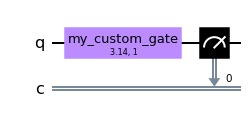

In [237]:

circ = transpile(circ, backend)
circ.draw('mpl', idle_wires=False)

In [235]:
job = execute(circ,backend)
from qiskit.tools.monitor import job_monitor
job_monitor(job)
result=job.result()
counts=result.get_counts()

Job Status: job has successfully run


QiskitError: 'ERROR:  [Experiment 0] Circuit contains invalid instructions {"gates": {my_custom_gate}} for "density_matrix" method ,  ERROR: Circuit contains invalid instructions {"gates": {my_custom_gate}} for "density_matrix" method'

### Your code goes here

The below block is where your SWAP gate can be inserted in order to be characterized. The code below uses the standard implementation of a SWAP gate in Qiskit as an example.

In [238]:
import numpy as np
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, schedule
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.visualization.pulse_v2 import draw, IQXDebugging
from qiskit.providers.aer import QasmSimulator
from qiskit import pulse
from qiskit.pulse import DriveChannel, ControlChannel, Play, Schedule, Waveform
from qiskit.pulse.library import drag, GaussianSquare, Gaussian
from qiskit.circuit import Gate

##############################################################################################




IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science')
backend = provider.get_backend('ibmq_casablanca')

################################################################################################

## load all the backend parameters for pulse
back_defaults = backend.defaults()
back_configuration = backend.configuration()
back_properties = backend.properties()
inst_map = back_defaults.instruction_schedule_map

dt = back_configuration.dt

#################################################################################################
control = 6
target = 5
##################################################################################################




# extracting the pre_CR instructions
cx_schedule = inst_map.get("cx", qubits=[control, target])
pre_instructions = cx_schedule.instructions[0:3]
#assert len(cr_instructions) == 5, f"{cr_instructions} should have 5 instructions"
#pre_instructions

#converting the pre_instructions to a schedule
pre_schedule = Schedule()
for (time, instruction) in pre_instructions:
    pre_schedule = pre_schedule.insert(time, instruction)
#draw(pre_schedule,style=IQXDebugging(), backend = backend) 

ibmqfactory.load_account:WARNING:2021-04-18 21:22:55,328: Credentials are already in use. The existing account in the session will be replaced.


In [239]:
# extracting CR(pi/4) instructions

cx_schedule = inst_map.get("cx", qubits=[control, target])
cr_start_index = -1  
for i, (_, instruction) in enumerate(cx_schedule.instructions):
        # the Cross-Resonance within the CNOT starts with a GaussianSquare Play instruction
        if isinstance(instruction, Play):
            if isinstance(instruction.pulse, pulse.library.parametric_pulses.GaussianSquare):
                cr_start_index = i
                break  
assert cr_start_index != -1, "did not find the start of CR"    
cr_instructions = cx_schedule.instructions[cr_start_index:cr_start_index+2]

In [240]:
#cr_instructions

#CR(pi/8 pulse)
subtract_width = int(cr_instructions[1][1].pulse.width/2)

new_crp_pulse_duration = cr_instructions[1][1].pulse.duration - subtract_width
new_crp_pulse_amp = cr_instructions[1][1].pulse.amp
new_crp_pulse_sigma = cr_instructions[1][1].pulse.sigma
new_crp_pulse_width = cr_instructions[1][1].pulse.width - subtract_width
new_crp_pulse = GaussianSquare(duration = new_crp_pulse_duration, amp = new_crp_pulse_amp, sigma = new_crp_pulse_sigma, width = new_crp_pulse_width, name = 'new_crp_pulse') 


# CR(-pi/8) pulse
new_crm_pulse_duration = cr_instructions[1][1].pulse.duration - subtract_width
new_crm_pulse_amp = -cr_instructions[1][1].pulse.amp
new_crm_pulse_sigma = cr_instructions[1][1].pulse.sigma
new_crm_pulse_width = cr_instructions[1][1].pulse.width - subtract_width
new_crm_pulse = GaussianSquare(duration = new_crm_pulse_duration, amp = new_crm_pulse_amp, sigma = new_crm_pulse_sigma, width = new_crm_pulse_width, name = 'new_crm_pulse') 


#active cancellation plus pulse
new_cancelp_pulse_duration = cr_instructions[0][1].pulse.duration - subtract_width
new_cancelp_pulse_amp = cr_instructions[0][1].pulse.amp
new_cancelp_pulse_sigma = cr_instructions[0][1].pulse.sigma
new_cancelp_pulse_width = cr_instructions[0][1].pulse.width - subtract_width
new_cancelp_pulse = GaussianSquare(duration = new_cancelp_pulse_duration, amp = new_cancelp_pulse_amp, sigma = new_cancelp_pulse_sigma, width = new_cancelp_pulse_width, name = 'new_cancelp_pulse') 



# active cancellation minus pulse
new_cancelm_pulse_duration = cr_instructions[0][1].pulse.duration - subtract_width
new_cancelm_pulse_amp = -cr_instructions[0][1].pulse.amp
new_cancelm_pulse_sigma = cr_instructions[0][1].pulse.sigma
new_cancelm_pulse_width = cr_instructions[0][1].pulse.width - subtract_width
new_cancelm_pulse = GaussianSquare(duration = new_cancelm_pulse_duration, amp = new_cancelm_pulse_amp, sigma = new_cancelm_pulse_sigma, width = new_cancelm_pulse_width, name = 'new_cancelm_pulse') 



#creating the x_pulse for control qubit
x_schedule= inst_map.get('x', qubits=[control])
x_pulse_control = x_schedule.instructions[0][1].pulse


#creating the x_pulse for target qubit
x_schedule = inst_map.get('x', qubits=[target])
x_pulse_target = x_schedule.instructions[0][1].pulse


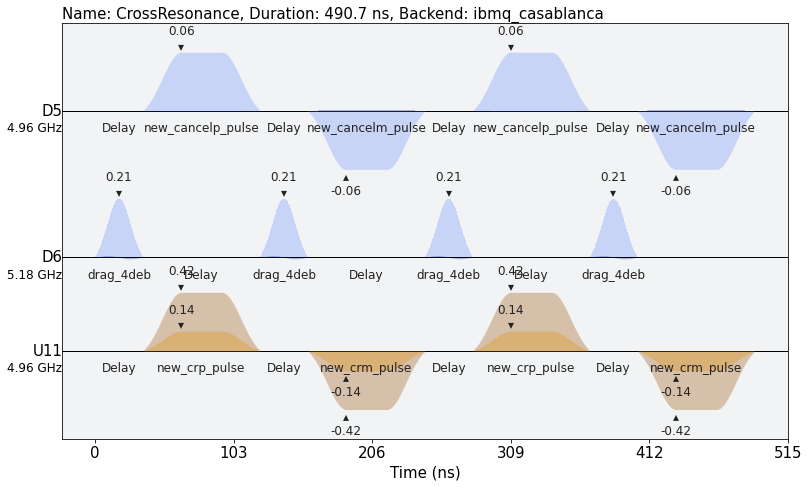

In [258]:
# build a cr(-pi/2) from cr(-pi/8) schedule 

with pulse.build(backend,name='CrossResonance') as cr_schedule:
    
    control_qubit_driveChannel = pulse.drive_channel(control) 
    target_qubit_driveChannel = pulse.drive_channel(target)
    control_channel = cr_instructions[1][1].channel
    
    pulse.play(x_pulse_control,control_qubit_driveChannel)
    
    pulse.delay(x_pulse_control.duration,control_channel)
    pulse.delay(x_pulse_control.duration,target_qubit_driveChannel)
    
    pulse.play(new_crp_pulse,control_channel) 
    pulse.play(new_cancelp_pulse,target_qubit_driveChannel)
    
    pulse.delay(new_crp_pulse.duration,control_qubit_driveChannel)
    
    pulse.play(x_pulse_control,control_qubit_driveChannel)
    
    pulse.delay(x_pulse_control.duration,control_channel)
    pulse.delay(x_pulse_control.duration,target_qubit_driveChannel)
    
    pulse.play(new_crm_pulse,control_channel)
    pulse.play(new_cancelm_pulse,target_qubit_driveChannel)
    
    pulse.delay(new_crm_pulse.duration,control_qubit_driveChannel)
    
    pulse.play(x_pulse_control,control_qubit_driveChannel)
    
    pulse.delay(x_pulse_control.duration,control_channel)
    pulse.delay(x_pulse_control.duration,target_qubit_driveChannel)
    
    pulse.play(new_crp_pulse,control_channel) 
    pulse.play(new_cancelp_pulse,target_qubit_driveChannel)
    
    pulse.delay(new_crp_pulse.duration,control_qubit_driveChannel)
    
    pulse.play(x_pulse_control,control_qubit_driveChannel)
    
    pulse.delay(x_pulse_control.duration,control_channel)
    pulse.delay(x_pulse_control.duration,target_qubit_driveChannel)
    
    pulse.play(new_crm_pulse,control_channel)
    pulse.play(new_cancelm_pulse,target_qubit_driveChannel)
    
    
draw(cr_schedule, style=IQXDebugging(), backend = backend)    

In [259]:

# build a cnot schedule

cnot_schedule = Schedule()
cnot_schedule = pre_schedule + cr_schedule 
    
#draw(cnot_schedule, style=IQXDebugging(), backend = backend)    




In [260]:

# Create abstract quantum gate of pulse schedule.
cnot_gate = Gate('cnot_gate', 2,[])

# Add cnot_gate to basis_gates and inst_map.
back_configuration.basis_gates += ['cnot_gate']
inst_map.add(cnot_gate, [control, target], cnot_schedule)



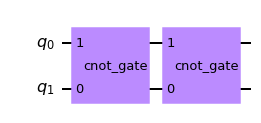

In [267]:
###########################################################################################



qc_swap = QuantumCircuit(2)
qc = 1
qt = 0
cnot_gate = Gate('cnot_gate', 2, [])
qc_swap.append(cnot_gate,(qc,qt))
#qc_swap.h(qc)
#qc_swap.h(qt)
qc_swap.append(cnot_gate,(qc,qt))
#qc_swap.h(qc)
#qc_swap.h(qt)
#qc_swap.append(cnot_gate,(qc,qt))

qc_swap.draw("mpl")

############################################################################################


In [268]:
len(interleaved_elem) 


1

In [269]:
len(rb_pattern) 

1

In [270]:
qc_swap.add_calibration('cnot_gate',[control,target],cnot_schedule,[])
#qc_swap=transpile(qc_swap, backend = backend, optimization_level=1, initial_layout=[0,1])
#transpiled_swap_circuit.draw()
#qc_swap.draw()

In [271]:
interleaved_elem = [qc_swap]
print(interleaved_elem)
print(rb_pattern)

[[5, 6]]


In [272]:
# Generate the RB circuits
rb_circs, xdata, circuits_interleaved = rb.randomized_benchmarking_seq(length_vector=length_vector,
                                             nseeds=nseeds,
                                             rb_pattern=rb_pattern,
                                             interleaved_elem=[qc_swap])

QiskitError: 'Cannot apply Instruction: cnot_gate'

In [187]:
# Execute the non-interleaved RB circuits as a reference 
shots=1000
basis_gates = ['u1','u2','u3','cx'] # use U,CX for now
result_list = []
transpile_list = []
for rb_seed,rb_circ_seed in enumerate(rb_circs):
    print('Compiling seed %d'%rb_seed)
    rb_circ_transpile = transpile(rb_circ_seed, basis_gates=basis_gates)
    print('Simulating seed %d'%rb_seed)
    job = execute(rb_circ_transpile, shots=shots, backend=backend)
    job_monitor(job)
                
    result_list.append(job.result())
    transpile_list.append(rb_circ_transpile)    
print("Finished Simulating")

Compiling seed 0
Simulating seed 0
Job Status: job is queued (None)  

KeyboardInterrupt: 

In [ ]:
# Plot the non-interleaved RB results
rbfit = rb.fitters.RBFitter(result_list[0], xdata, rb_pattern)

for seed_num, data in enumerate(result_list):#range(1,len(result_list)):  
    plt.figure(figsize=(6, 6))
    axis = [plt.subplot(1, 1, 1)]
    
    # Add another seed to the data
    rbfit.add_data([data])
    
    for i in range(1):
        pattern_ind = i

        # Plot the essence by calling plot_rb_data
        rbfit.plot_rb_data(pattern_ind, ax=axis[i], add_label=True, show_plt=False)

        # Add title and label
        axis[i].set_title('2 Qubit RB - after seed %d'%(seed_num), fontsize=18)
        
    # Display
    display(plt.gcf())
    
    # Clear display after each seed and close
    clear_output(wait=True)
    time.sleep(1.0)
    plt.close()

In [ ]:
# Execute the interleaved RB circuits
shots=1000
basis_gates = ['u1','u2','u3','cx'] # use U,CX for now
interleaved_result_list = []
interleaved_transpile_list = []
for rb_seed,rb_circ_seed in enumerate(circuits_interleaved):
    print('Compiling seed %d'%rb_seed)
    rb_circ_transpile = transpile(rb_circ_seed, basis_gates=basis_gates)
    print('Simulating seed %d'%rb_seed)
    job = execute(rb_circ_transpile, shots=shots, backend=backend)
    interleaved_result_list.append(job.result())
    interleaved_transpile_list.append(rb_circ_transpile)    
print("Finished Simulating")

In [ ]:
# Plot the interleaved RB circuit results
rbfit = rb.fitters.RBFitter(interleaved_result_list[0], xdata, rb_pattern)

for seed_num, data in enumerate(interleaved_result_list):#range(1,len(result_list)):  
    plt.figure(figsize=(6, 6))
    axis = [plt.subplot(1, 1, 1)]
    
    # Add another seed to the data
    rbfit.add_data([data])
    
    for i in range(1):
        pattern_ind = i

        # Plot the essence by calling plot_rb_data
        rbfit.plot_rb_data(pattern_ind, ax=axis[i], add_label=True, show_plt=False)

        # Add title and label
        axis[i].set_title('2 Qubit RB - after seed %d'%(seed_num), fontsize=18)
        
    # Display
    display(plt.gcf())
    
    # Clear display after each seed and close
    clear_output(wait=True)
    time.sleep(1.0)
    plt.close()

In [ ]:
# Extract the interleaved results and plot
rb_fit_interleaved = InterleavedRBFitter(result_list, interleaved_result_list, xdata, rb_pattern)

In [ ]:
plt.figure(figsize=(8, 8))
axis = [plt.subplot(1, 1, 1)]
rb_fit_interleaved.plot_rb_data(ax=axis[0],add_label=True, show_plt=False)

We see that the standard `SWAP` has an error of 2.047%.

## Pulse `SWAP`

In this section we will outline the basic steps of constructing a custom gate using Qiskit Pulse which can then be characterized with the above techniques demonstrated in the above sections.

First let's set up by loading the backend details for Qiskit Pulse.

In [ ]:
backend = provider.get_backend('ibmq_casablanca')

In [ ]:
## load all the backend parameters for pulse
back_defaults = backend.defaults()
back_configuration = backend.configuration()
back_properties = backend.properties()
inst_map = back_defaults.instruction_schedule_map

Next, let's take a look at the pulse schedule for the standard `SWAP` gate in Qiskit.

In [ ]:
qc_swap_transpiled = transpile(qc_swap, backend, optimization_level=1)
sched = schedule(qc_swap_transpiled, backend, inst_map=inst_map)
sched.draw()

The gate is constructed by 3 `CNOT` gates where each `CNOT` consists of a 2 pulse echoed cross-resonance (CR) drive (https://arxiv.org/pdf/1603.04821.pdf) applied to the control qubit (u1 in the figure) and a on resonant 'rotary echo' (https://arxiv.org/pdf/2007.02925.pdf) applied to the target qubit. The direction of the `CNOT` can be flipped by applying hadamard gates to both qubits before and after the CR drive.

You may construct a custom gate using Qiskit Pulse, following these tutorials: [[pulse instructions]](https://github.com/Qiskit/qiskit-tutorials/blob/master/tutorials/circuits_advanced/06_building_pulse_instructions.ipynb) [[pulse schedules]](https://github.com/Qiskit/qiskit-tutorials/blob/master/tutorials/circuits_advanced/07_building_pulse_schedules.ipynb)

Once your gate is defined as a circuit element, drop it into this notebook above in order to see how well it performs!

## Qiskit version

In [ ]:
%qiskit_version_table